In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np


# Data Loading and One-hot encoding

In [ ]:
import pandas as pd
data=pd.read_csv("./input.out",sep="\t")

In [ ]:
df = pd.DataFrame(data)


In [ ]:
max_length = df['sequence'].str.len().max()

# Define a function to convert and pad sequences
def encode_and_pad(seq):
    mapping = {'A': [1, 0, 0, 0], 'T': [0, 1, 0, 0], 'C': [0, 0, 1, 0], 'G': [0, 0, 0, 1]}
    encoded = np.array([mapping[s] for s in seq] + [[0, 0, 0, 0]] * (max_length - len(seq)))  # pad with zeros
    return encoded

# Apply encoding and padding
df['encoded'] = df['sequence'].apply(encode_and_pad)

In [ ]:
print(max_length)

9243


In [ ]:
labels = torch.tensor(df['class'].values)
features = torch.tensor(np.array(df['encoded'].tolist()), dtype=torch.float32)

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training, validation, and testing sets
train_val_features, test_features, train_val_labels, test_labels = train_test_split(
    features, labels, test_size=0.2, random_state=42)  #

train_features, val_features, train_labels, val_labels = train_test_split(
    train_val_features, train_val_labels, test_size=0.22, random_state=42)  # 22% of 90% for validation

# Convert to TensorDatasets
train_dataset = TensorDataset(train_features, train_labels)
val_dataset = TensorDataset(val_features, val_labels)
test_dataset = TensorDataset(test_features, test_labels)

torch.save(train_dataset, 'train_dataset.pt')
torch.save(val_dataset, 'val_dataset.pt')
torch.save(test_dataset, 'test_dataset.pt')


In [ ]:
train_dataset = torch.load('train_dataset.pt')
val_dataset = torch.load('val_dataset.pt')
test_dataset = torch.load('test_dataset.pt')

# Create DataLoaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# CNN Models

In [ ]:
class DNACNN(nn.Module):
    def __init__(self):
        super(DNACNN, self).__init__()
        self.conv1 = nn.Conv1d(4, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2, 2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        # Assuming output dimension from conv layers correctly calculated for linear layer
        self.fc1 = nn.Linear(32 * (9243 // 4), 64)
        self.fc2 = nn.Linear(64, 7)  # Change 2 to the actual number of classes you need
        self.activation = nn.ReLU()

    def forward(self, x):
      if x.shape[1] != 4:
        x = x.permute(0, 2, 1)
      x = self.pool(self.activation(self.conv1(x)))
      x = self.pool(self.activation(self.conv2(x)))
      x = x.view(-1, 32 * (max_length // 4))  # Flatten for the fully connected layer
      x = self.activation(self.fc1(x))
      x = self.fc2(x)
      return x
# Check for GPU
# device = "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Instantiate the model and move it to the GPU if available
model = DNACNN().to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


Using cuda device


In [ ]:
# Import required metrics and tools
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def evaluate(model, loader, device):
    model.eval()
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():
        for sequences, labels in loader:
            sequences, labels = sequences.to(device), labels.to(device)
            labels = labels.type(torch.LongTensor)
            outputs = model(sequences)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy()[:, 1])  # Probability scores for class 1
    return y_true, y_pred, y_scores




def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve')
    plt.show()

# Train the model
# model.train()
# Modify your training loop
for epoch in range(30):  # Run for more epochs depending on your dataset size and complexity
    model.train()
    train_true, train_pred, train_scores = [], [], []
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        labels = labels.type(torch.LongTensor).to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Optionally collect predictions to calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_true.extend(labels.cpu().numpy())
        train_pred.extend(predicted.cpu().numpy())

    # Calculate training accuracy
    train_accuracy = accuracy_score(train_true, train_pred)
    print(f'Epoch {epoch+1}, Training Accuracy: {train_accuracy:.2f}')

    # Validation
    val_true, val_pred, val_scores = evaluate(model, val_loader, device)
    val_accuracy = accuracy_score(val_true, val_pred)
    print(f'Epoch {epoch+1}, Validation Accuracy: {val_accuracy:.2f}')




Epoch 1, Training Accuracy: 0.33
Epoch 1, Validation Accuracy: 0.35
Epoch 2, Training Accuracy: 0.38
Epoch 2, Validation Accuracy: 0.45
Epoch 3, Training Accuracy: 0.48
Epoch 3, Validation Accuracy: 0.54
Epoch 4, Training Accuracy: 0.59
Epoch 4, Validation Accuracy: 0.60
Epoch 5, Training Accuracy: 0.67
Epoch 5, Validation Accuracy: 0.62
Epoch 6, Training Accuracy: 0.73
Epoch 6, Validation Accuracy: 0.66
Epoch 7, Training Accuracy: 0.77
Epoch 7, Validation Accuracy: 0.71
Epoch 8, Training Accuracy: 0.81
Epoch 8, Validation Accuracy: 0.71
Epoch 9, Training Accuracy: 0.84
Epoch 9, Validation Accuracy: 0.75
Epoch 10, Training Accuracy: 0.87
Epoch 10, Validation Accuracy: 0.75
Epoch 11, Training Accuracy: 0.88
Epoch 11, Validation Accuracy: 0.75
Epoch 12, Training Accuracy: 0.89
Epoch 12, Validation Accuracy: 0.76
Epoch 13, Training Accuracy: 0.90
Epoch 13, Validation Accuracy: 0.77
Epoch 14, Training Accuracy: 0.92
Epoch 14, Validation Accuracy: 0.78
Epoch 15, Training Accuracy: 0.92
Epoc

In [ ]:
# Testing and Metrics
test_true, test_pred, test_scores = evaluate(model, test_loader, device)
test_accuracy = accuracy_score(test_true, test_pred)
conf_matrix = confusion_matrix(test_true, test_pred)


print("Testing Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)



Testing Accuracy: 0.7984615384615384
Confusion Matrix:
 [[148   3   2   6   6   2   7]
 [  2 125   8   6   3   0  13]
 [  1   5  77   8   4   0  19]
 [  4   4   0 147  10   1  15]
 [ 11   9   2  12 149   2  21]
 [  1   3   1   2   6  59   2]
 [  2  15   4  23  16   1 333]]


In [ ]:
# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class DNACNN(nn.Module):
    def __init__(self):
        super(DNACNN, self).__init__()
        self.conv1 = nn.Conv1d(4, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2, 2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        # Assuming output dimension from conv layers correctly calculated for linear layer
        self.fc1 = nn.Linear(32 * (9243 // 4), 64)
        self.fc2 = nn.Linear(64, 7)  # Change 2 to the actual number of classes you need
        self.activation = nn.ReLU()

    def forward(self, x):
      if x.shape[1] != 4:
        x = x.permute(0, 2, 1)
      x = self.pool(self.activation(self.conv1(x)))
      x = self.pool(self.activation(self.conv2(x)))
      x = x.view(-1, 32 * (max_length // 4))  # Flatten for the fully connected layer
      x = self.activation(self.fc1(x))
      x = self.fc2(x)
      return x
# Check for GPU
# device = "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Instantiate the model and move it to the GPU if available
model = DNACNN().to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


Using cuda device


In [ ]:
# Import required metrics and tools
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def evaluate(model, loader, device):
    model.eval()
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():
        for sequences, labels in loader:
            sequences, labels = sequences.to(device), labels.to(device)
            labels = labels.type(torch.LongTensor)
            outputs = model(sequences)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy()[:, 1])  # Probability scores for class 1
    return y_true, y_pred, y_scores




def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve')
    plt.show()

# Train the model
# model.train()
# Modify your training loop
for epoch in range(30):  # Run for more epochs depending on your dataset size and complexity
    model.train()
    train_true, train_pred, train_scores = [], [], []
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        labels = labels.type(torch.LongTensor).to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Optionally collect predictions to calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_true.extend(labels.cpu().numpy())
        train_pred.extend(predicted.cpu().numpy())

    # Calculate training accuracy
    train_accuracy = accuracy_score(train_true, train_pred)
    print(f'Epoch {epoch+1}, Training Accuracy: {train_accuracy:.2f}')

    # Validation
    val_true, val_pred, val_scores = evaluate(model, val_loader, device)
    val_accuracy = accuracy_score(val_true, val_pred)
    print(f'Epoch {epoch+1}, Validation Accuracy: {val_accuracy:.2f}')

Epoch 1, Training Accuracy: 0.31
Epoch 1, Validation Accuracy: 0.34
Epoch 2, Training Accuracy: 0.36
Epoch 2, Validation Accuracy: 0.39
Epoch 3, Training Accuracy: 0.41
Epoch 3, Validation Accuracy: 0.40
Epoch 4, Training Accuracy: 0.48
Epoch 4, Validation Accuracy: 0.47
Epoch 5, Training Accuracy: 0.56
Epoch 5, Validation Accuracy: 0.57
Epoch 6, Training Accuracy: 0.64
Epoch 6, Validation Accuracy: 0.62
Epoch 7, Training Accuracy: 0.70
Epoch 7, Validation Accuracy: 0.65
Epoch 8, Training Accuracy: 0.73
Epoch 8, Validation Accuracy: 0.67
Epoch 9, Training Accuracy: 0.78
Epoch 9, Validation Accuracy: 0.67
Epoch 10, Training Accuracy: 0.80
Epoch 10, Validation Accuracy: 0.70
Epoch 11, Training Accuracy: 0.81
Epoch 11, Validation Accuracy: 0.73
Epoch 12, Training Accuracy: 0.84
Epoch 12, Validation Accuracy: 0.75
Epoch 13, Training Accuracy: 0.86
Epoch 13, Validation Accuracy: 0.75
Epoch 14, Training Accuracy: 0.87
Epoch 14, Validation Accuracy: 0.75
Epoch 15, Training Accuracy: 0.88
Epoc

In [ ]:
# Testing and Metrics
test_true, test_pred, test_scores = evaluate(model, test_loader, device)
test_accuracy = accuracy_score(test_true, test_pred)
conf_matrix = confusion_matrix(test_true, test_pred)


print("Testing Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)

Testing Accuracy: 0.7915384615384615
Confusion Matrix:
 [[134   4   2   6  14   4  10]
 [  1 127   2  11   7   0   9]
 [  1   5  73   2  13   0  20]
 [  1   6   0 142  13   0  19]
 [  5   5   2  12 158   2  22]
 [  2   4   0   4   8  47   9]
 [  2  11   1  14  16   2 348]]


In [ ]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class DNACNN(nn.Module):
    def __init__(self):
        super(DNACNN, self).__init__()
        self.conv1 = nn.Conv1d(4, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2, 2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        # Assuming output dimension from conv layers correctly calculated for linear layer
        self.fc1 = nn.Linear(32 * (9243 // 4), 64)
        self.fc2 = nn.Linear(64, 7)  # Change 2 to the actual number of classes you need
        self.activation = nn.ReLU()

    def forward(self, x):
      if x.shape[1] != 4:
        x = x.permute(0, 2, 1)
      x = self.pool(self.activation(self.conv1(x)))
      x = self.pool(self.activation(self.conv2(x)))
      x = x.view(-1, 32 * (max_length // 4))  # Flatten for the fully connected layer
      x = self.activation(self.fc1(x))
      x = self.fc2(x)
      return x
# Check for GPU
# device = "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Instantiate the model and move it to the GPU if available
model = DNACNN().to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Using cuda device


In [ ]:
# Import required metrics and tools
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def evaluate(model, loader, device):
    model.eval()
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():
        for sequences, labels in loader:
            sequences, labels = sequences.to(device), labels.to(device)
            labels = labels.type(torch.LongTensor)
            outputs = model(sequences)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy()[:, 1])  # Probability scores for class 1
    return y_true, y_pred, y_scores




def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve')
    plt.show()

# Train the model
# model.train()
# Modify your training loop
for epoch in range(30):  # Run for more epochs depending on your dataset size and complexity
    model.train()
    train_true, train_pred, train_scores = [], [], []
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        labels = labels.type(torch.LongTensor).to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Optionally collect predictions to calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_true.extend(labels.cpu().numpy())
        train_pred.extend(predicted.cpu().numpy())

    # Calculate training accuracy
    train_accuracy = accuracy_score(train_true, train_pred)
    print(f'Epoch {epoch+1}, Training Accuracy: {train_accuracy:.2f}')

    # Validation
    val_true, val_pred, val_scores = evaluate(model, val_loader, device)
    val_accuracy = accuracy_score(val_true, val_pred)
    print(f'Epoch {epoch+1}, Validation Accuracy: {val_accuracy:.2f}')

Epoch 1, Training Accuracy: 0.32
Epoch 1, Validation Accuracy: 0.34
Epoch 2, Training Accuracy: 0.34
Epoch 2, Validation Accuracy: 0.33
Epoch 3, Training Accuracy: 0.34
Epoch 3, Validation Accuracy: 0.35
Epoch 4, Training Accuracy: 0.36
Epoch 4, Validation Accuracy: 0.34
Epoch 5, Training Accuracy: 0.37
Epoch 5, Validation Accuracy: 0.37
Epoch 6, Training Accuracy: 0.41
Epoch 6, Validation Accuracy: 0.45
Epoch 7, Training Accuracy: 0.47
Epoch 7, Validation Accuracy: 0.46
Epoch 8, Training Accuracy: 0.51
Epoch 8, Validation Accuracy: 0.49
Epoch 9, Training Accuracy: 0.56
Epoch 9, Validation Accuracy: 0.56
Epoch 10, Training Accuracy: 0.59
Epoch 10, Validation Accuracy: 0.59
Epoch 11, Training Accuracy: 0.64
Epoch 11, Validation Accuracy: 0.61
Epoch 12, Training Accuracy: 0.67
Epoch 12, Validation Accuracy: 0.62
Epoch 13, Training Accuracy: 0.70
Epoch 13, Validation Accuracy: 0.65
Epoch 14, Training Accuracy: 0.72
Epoch 14, Validation Accuracy: 0.66
Epoch 15, Training Accuracy: 0.74
Epoc

In [ ]:
# Testing and Metrics
test_true, test_pred, test_scores = evaluate(model, test_loader, device)
test_accuracy = accuracy_score(test_true, test_pred)
conf_matrix = confusion_matrix(test_true, test_pred)


print("Testing Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)

Testing Accuracy: 0.7592307692307693
Confusion Matrix:
 [[141   2   0   5  12   3  11]
 [  5 114   5   5   6   0  22]
 [  1   3  74   5   6   1  24]
 [  0   5   2 110  21   3  40]
 [ 13   7   4   9 140   0  33]
 [  4   2   3   0   9  44  12]
 [  2   4   3   7  13   1 364]]


In [ ]:
# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class DNACNN(nn.Module):
    def __init__(self):
        super(DNACNN, self).__init__()
        self.conv1 = nn.Conv1d(4, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2, 2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        # Assuming output dimension from conv layers correctly calculated for linear layer
        self.fc1 = nn.Linear(32 * (9243 // 4), 64)
        self.fc2 = nn.Linear(64, 7)  # Change 2 to the actual number of classes you need
        self.activation = nn.ReLU()

    def forward(self, x):
      if x.shape[1] != 4:
        x = x.permute(0, 2, 1)
      x = self.pool(self.activation(self.conv1(x)))
      x = self.pool(self.activation(self.conv2(x)))
      x = x.view(-1, 32 * (max_length // 4))  # Flatten for the fully connected layer
      x = self.activation(self.fc1(x))
      x = self.fc2(x)
      return x
# Check for GPU
# device = "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Instantiate the model and move it to the GPU if available
model = DNACNN().to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Using cuda device


In [ ]:
# Import required metrics and tools
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def evaluate(model, loader, device):
    model.eval()
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():
        for sequences, labels in loader:
            sequences, labels = sequences.to(device), labels.to(device)
            labels = labels.type(torch.LongTensor)
            outputs = model(sequences)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy()[:, 1])  # Probability scores for class 1
    return y_true, y_pred, y_scores




def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve')
    plt.show()

# Train the model
# model.train()
# Modify your training loop
for epoch in range(30):  # Run for more epochs depending on your dataset size and complexity
    model.train()
    train_true, train_pred, train_scores = [], [], []
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        labels = labels.type(torch.LongTensor).to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Optionally collect predictions to calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_true.extend(labels.cpu().numpy())
        train_pred.extend(predicted.cpu().numpy())

    # Calculate training accuracy
    train_accuracy = accuracy_score(train_true, train_pred)
    print(f'Epoch {epoch+1}, Training Accuracy: {train_accuracy:.2f}')

    # Validation
    val_true, val_pred, val_scores = evaluate(model, val_loader, device)
    val_accuracy = accuracy_score(val_true, val_pred)
    print(f'Epoch {epoch+1}, Validation Accuracy: {val_accuracy:.2f}')

Epoch 1, Training Accuracy: 0.31
Epoch 1, Validation Accuracy: 0.33
Epoch 2, Training Accuracy: 0.34
Epoch 2, Validation Accuracy: 0.33
Epoch 3, Training Accuracy: 0.34
Epoch 3, Validation Accuracy: 0.34
Epoch 4, Training Accuracy: 0.36
Epoch 4, Validation Accuracy: 0.36
Epoch 5, Training Accuracy: 0.38
Epoch 5, Validation Accuracy: 0.36
Epoch 6, Training Accuracy: 0.40
Epoch 6, Validation Accuracy: 0.43
Epoch 7, Training Accuracy: 0.43
Epoch 7, Validation Accuracy: 0.42
Epoch 8, Training Accuracy: 0.50
Epoch 8, Validation Accuracy: 0.42
Epoch 9, Training Accuracy: 0.52
Epoch 9, Validation Accuracy: 0.52
Epoch 10, Training Accuracy: 0.57
Epoch 10, Validation Accuracy: 0.57
Epoch 11, Training Accuracy: 0.61
Epoch 11, Validation Accuracy: 0.55
Epoch 12, Training Accuracy: 0.65
Epoch 12, Validation Accuracy: 0.59
Epoch 13, Training Accuracy: 0.67
Epoch 13, Validation Accuracy: 0.62
Epoch 14, Training Accuracy: 0.70
Epoch 14, Validation Accuracy: 0.64
Epoch 15, Training Accuracy: 0.72
Epoc

In [ ]:
# Testing and Metrics
test_true, test_pred, test_scores = evaluate(model, test_loader, device)
test_accuracy = accuracy_score(test_true, test_pred)
conf_matrix = confusion_matrix(test_true, test_pred)


print("Testing Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)

Testing Accuracy: 0.7453846153846154
Confusion Matrix:
 [[140   5   1   2  11   0  15]
 [  9 108   3   9   8   0  20]
 [  4   3  69   2  13   0  23]
 [  3   9   1 111  22   2  33]
 [ 11   2   1  15 142   1  34]
 [  6   2   1   2   5  47  11]
 [  7   5   1   8  21   0 352]]


# Transformer Model

In [ ]:
class DNA_Transformer(nn.Module):
    def __init__(self, num_classes, d_model=4, nhead=2, num_encoder_layers=3, dim_feedforward=2048, dropout=0.1):
        super(DNA_Transformer, self).__init__()
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,   # Matched to the number of features in the input data
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=num_encoder_layers)
        self.output_layer = nn.Linear(d_model, num_classes)

    def forward(self, src):
        src = src.permute(1, 0, 2)  # Transformer expects src in shape [seq_len, batch_size, features]
        transformer_output = self.transformer_encoder(src)
        output = self.output_layer(transformer_output[-1])  # Use the output of the last sequence position
        return output

# Adjust the number of heads if necessary. Since `d_model` is now `4`, `nhead` must be a divisor of `4`.



# Example parameters
batch_size =16
seq_length = 9245
num_features = 4  # One-hot encoded DNA (A, C, G, T)
num_classes = 7
model = DNA_Transformer(num_classes=num_classes, d_model=4, nhead=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)




/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
class DNA_Transformer(nn.Module):
    def __init__(self, num_classes, d_model=4, nhead=2, num_encoder_layers=3, dim_feedforward=2048, dropout=0.1):
        super(DNA_Transformer, self).__init__()
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,   # Matched to the number of features in the input data
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=num_encoder_layers)
        self.output_layer = nn.Linear(d_model, num_classes)

    def forward(self, src):
        src = src.permute(1, 0, 2)  # Transformer expects src in shape [seq_len, batch_size, features]
        transformer_output = self.transformer_encoder(src)
        output = self.output_layer(transformer_output[-1])  # Use the output of the last sequence position
        return output

# Adjust the number of heads if necessary. Since `d_model` is now `4`, `nhead` must be a divisor of `4`.



# Example parameters
batch_size =16
seq_length = 9245
num_features = 4  # One-hot encoded DNA (A, C, G, T)
num_classes = 7
model = DNA_Transformer(num_classes=num_classes, d_model=4, nhead=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Training Loop
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

    accuracy = 100 * correct / total
    return total_loss / len(dataloader), accuracy

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item()
            torch.cuda.empty_cache()
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
            all_preds.extend(predicted.view(-1).tolist())
            all_labels.extend(y.view(-1).tolist())

    accuracy = 100 * correct / total
    return total_loss / len(dataloader), accuracy, all_preds, all_labels

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# PATH = "/content/drive/MyDrive"
# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']



# Run training and validation
num_epochs = 30
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_preds, val_labels = validate_epoch(model, val_loader, criterion, device)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

# Evaluate the final model on training data
_, train_acc, train_preds, train_labels = validate_epoch(model, train_loader, criterion, device)
print(f'Training Accuracy: {train_acc:.2f}%')

# Confusion Matrix
cm = confusion_matrix(train_labels, train_preds)
print('Confusion Matrix:')
print(cm)


Epoch 1, Train Loss: 1.8381, Train Acc: 30.74%, Val Loss: 1.8157, Val Acc: 32.17%
Epoch 2, Train Loss: 1.8083, Train Acc: 30.65%, Val Loss: 1.7697, Val Acc: 32.17%
Epoch 3, Train Loss: 1.8079, Train Acc: 30.74%, Val Loss: 1.7708, Val Acc: 32.87%
Epoch 4, Train Loss: 1.7801, Train Acc: 31.43%, Val Loss: 1.7883, Val Acc: 28.76%
Epoch 5, Train Loss: 1.8122, Train Acc: 30.33%, Val Loss: 1.7976, Val Acc: 32.17%
Epoch 6, Train Loss: 1.7769, Train Acc: 31.95%, Val Loss: 1.7528, Val Acc: 32.60%
Epoch 7, Train Loss: 1.7777, Train Acc: 31.36%, Val Loss: 1.8230, Val Acc: 26.22%
Epoch 8, Train Loss: 1.7827, Train Acc: 31.76%, Val Loss: 1.7650, Val Acc: 32.60%
Epoch 9, Train Loss: 1.7692, Train Acc: 32.22%, Val Loss: 1.7513, Val Acc: 33.48%
Epoch 10, Train Loss: 1.7704, Train Acc: 32.22%, Val Loss: 1.7730, Val Acc: 32.52%
Epoch 11, Train Loss: 1.7659, Train Acc: 32.94%, Val Loss: 1.7430, Val Acc: 34.62%
Epoch 12, Train Loss: 1.7624, Train Acc: 32.96%, Val Loss: 1.7562, Val Acc: 32.87%
Epoch 13, Tra

# LSTM Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(4, enc_hid_dim, batch_first=True).cuda()
        # self.rnn = nn.LSTM(4, enc_hid_dim, batch_first=True)

        self.fc1 = nn.Linear(enc_hid_dim, enc_hid_dim)
        self.fc2 = nn.Linear(enc_hid_dim, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        outputs, (hidden, cell) = self.rnn(src)
        hidden = F.relu(self.fc1(hidden))
        hidden = torch.tanh(self.fc2(hidden))

        return outputs, hidden

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        # self.rnn = nn.LSTM(emb_dim + enc_hid_dim, dec_hid_dim, batch_first=True)
        self.rnn = nn.LSTM(emb_dim + enc_hid_dim, dec_hid_dim, batch_first=True).to(device)
        self.fc_out = nn.Linear(dec_hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def compute_attention(self, hidden, encoder_outputs):
        # Cosine similarity as attention
        hidden = hidden.permute(1, 0, 2)
        attention = torch.cosine_similarity(hidden, encoder_outputs, dim=2)
        return F.softmax(attention, dim=1)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(1)
        # print('input shape is:', input.shape)

        embedded = self.dropout(self.embedding(input))
        # print('embedded shape is:', embedded.shape)
        # print('hidden shape is:', hidden.shape)
        # print('encoder_outputs shape is:', encoder_outputs.shape)
        attention_weights = self.compute_attention(hidden, encoder_outputs)
        attention_applied = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)
        # print('attention_applied shape is:', attention_applied.shape)
        rnn_input = torch.cat((embedded, attention_applied), dim=2)

        output, (hidden, cell) = self.rnn(rnn_input, (hidden, hidden))
        prediction = self.fc_out(output.squeeze(1))

        return F.log_softmax(prediction, dim=1), hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        # self.encoder = encoder
        # self.decoder = decoder
        self.device = device

    def forward(self, source):
        # Encode


        encoder_outputs, hidden = self.encoder(source)
        # print('encoder_outputs shape is:', encoder_outputs.shape)
        # print('hidden shape is:', hidden.shape)
        batch_size = source.size(0)

        decoder_input = torch.zeros(batch_size, dtype=torch.long, device=self.device)
        # print('decoder_input shape is:', decoder_input.shape)
        # decoder_input = torch.zeros(batch_size, dtype=torch.long)

        outputs = []
        # outputs = torch.zeros(10, batch_size, 2, device=self.device)

        # Decode per timestep
        for t in range(batch_size):

          output, hidden, cell = self.decoder(decoder_input, hidden, encoder_outputs)
          # print('output shape is:', output.shape)
          outputs.append(output)
          # outputs[t] = output.argmax(0)

          top1 = output.argmax(1)
          decoder_input = top1

        # print('outputs shape is:', len(outputs))
        concatenated_output = torch.cat(outputs, dim=1)
        # print(f"Concatenated output requires_grad: {concatenated_output.requires_grad}")
        return concatenated_output


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = 4
output_dim = 7
emb_dim = 128  # Embedding size
enc_hid_dim = 256  # Encoder hidden dimension
dec_hid_dim = 256  # Decoder hidden dimension (should match LSTM output in encoder)
dropout_rate = 0.2
batch_size = 32

encoder = Encoder(input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout_rate)
decoder = Decoder(output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout_rate)
model = Seq2Seq(encoder, decoder, device).to(device)

# Result Vizualization

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

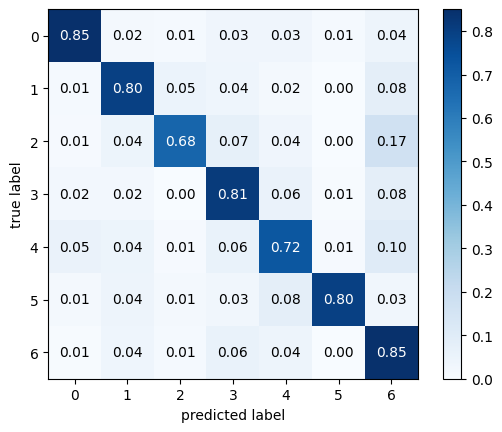

In [ ]:
#CNN batch=8
multiclass = np.array([
    [148,   3,   2,   6,   6,   2,   7],
    [  2, 125,   8,   6,   3,   0,  13],
    [  1,   5,  77,   8,   4,   0,  19],
    [  4,   4,   0, 147,  10,   1,  15],
    [ 11,   9,   2,  12, 149,   2,  21],
    [  1,   3,   1,   2,   6,  59,   2],
    [  2,  15,   4,  23,  16,   1, 333]
])


fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
def calculate_metrics(cm):
    # Extracting TP, FP, FN for each class
    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP
    TN = np.sum(cm) - (FP + FN + TP)

    # Precision, Recall, and F1 Score
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)

    # Class-wise accuracy
    accuracy = (TP + TN) / np.sum(cm)

    return precision, recall, f1, accuracy

precision, recall, f1_score, class_accuracy = calculate_metrics(multiclass)
print(precision)
print(recall)
print(f1_score)
print(class_accuracy)

[0.87573964 0.76219512 0.81914894 0.72058824 0.76804124 0.90769231
 0.81219512]
[0.85057471 0.79617834 0.6754386  0.8121547  0.72330097 0.7972973
 0.84517766]
[0.86297376 0.7788162  0.74038462 0.76363636 0.745      0.84892086
 0.82835821]
[0.96384615 0.94538462 0.95846154 0.93       0.92153846 0.98384615
 0.89384615]


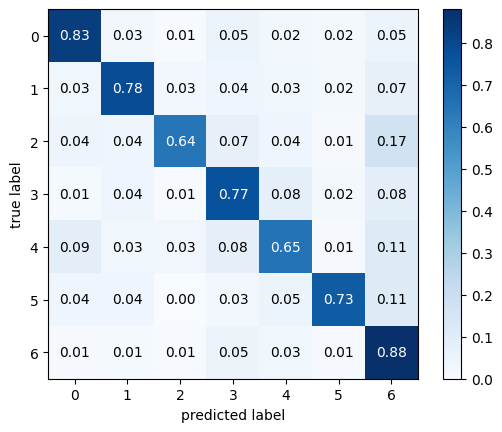

In [ ]:
#CNN batch=16
# Create the numpy array from the provided list of lists
multiclass = np.array([
    [145,   5,   1,   8,   4,   3,   8],
    [  5, 123,   4,   6,   5,   3,  11],
    [  5,   4,  73,   8,   4,   1,  19],
    [  2,   7,   1, 139,  14,   3,  15],
    [ 18,   7,   6,  17, 134,   2,  22],
    [  3,   3,   0,   2,   4,  54,   8],
    [  4,   5,   2,  20,  13,   3, 347]
])

fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
def calculate_metrics(cm):
    # Extracting TP, FP, FN for each class
    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP
    TN = np.sum(cm) - (FP + FN + TP)

    # Precision, Recall, and F1 Score
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)

    # Class-wise accuracy
    accuracy = (TP + TN) / np.sum(cm)

    return precision, recall, f1, accuracy

precision, recall, f1_score, class_accuracy = calculate_metrics(multiclass)
print(precision)
print(recall)
print(f1_score)
print(class_accuracy)

[0.7967033  0.7987013  0.83908046 0.695      0.75280899 0.7826087
 0.80697674]
[0.83333333 0.78343949 0.64035088 0.7679558  0.65048544 0.72972973
 0.88071066]
[0.81460674 0.79099678 0.72636816 0.72965879 0.69791667 0.75524476
 0.84223301]
[0.94923077 0.95       0.95769231 0.92076923 0.91076923 0.97307692
 0.9       ]


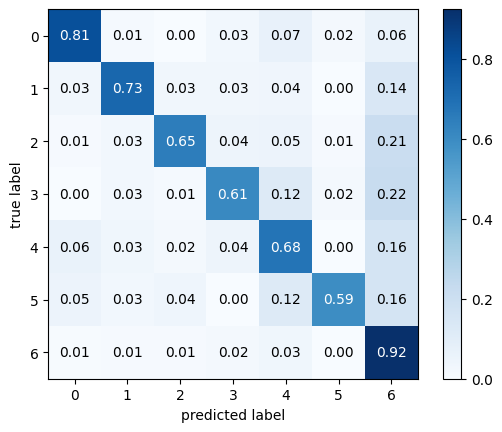

In [ ]:
#CNN batch=32
# Create the numpy array from the provided list of lists
# Create the numpy array from the provided list of lists
multiclass = np.array([
    [141,   2,   0,   5,  12,   3,  11],
    [  5, 114,   5,   5,   6,   0,  22],
    [  1,   3,  74,   5,   6,   1,  24],
    [  0,   5,   2, 110,  21,   3,  40],
    [ 13,   7,   4,   9, 140,   0,  33],
    [  4,   2,   3,   0,   9,  44,  12],
    [  2,   4,   3,   7,  13,   1, 364]
])

fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
def calculate_metrics(cm):
    # Extracting TP, FP, FN for each class
    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP
    TN = np.sum(cm) - (FP + FN + TP)

    # Precision, Recall, and F1 Score
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)

    # Class-wise accuracy
    accuracy = (TP + TN) / np.sum(cm)

    return precision, recall, f1, accuracy

precision, recall, f1_score, class_accuracy = calculate_metrics(multiclass)
print(precision)
print(recall)
print(f1_score)
print(class_accuracy)

[0.84939759 0.83211679 0.81318681 0.78014184 0.6763285  0.84615385
 0.71936759]
[0.81034483 0.72611465 0.64912281 0.60773481 0.67961165 0.59459459
 0.92385787]
[0.82941176 0.7755102  0.72195122 0.68322981 0.6779661  0.6984127
 0.80888889]
[0.95538462 0.94923077 0.95615385 0.92153846 0.89769231 0.97076923
 0.86769231]


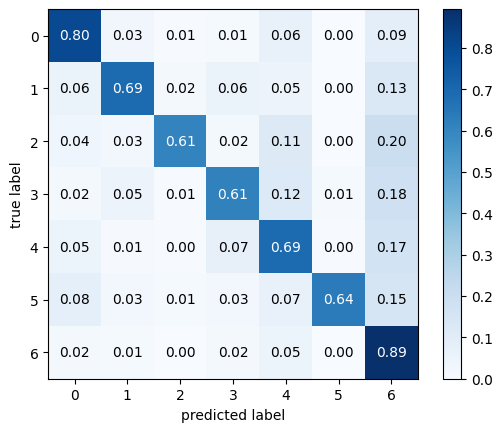

In [ ]:
#CNN batch=64
# Create the numpy array from the provided list of lists
# Create the numpy array from the provided list of lists
# Create the numpy array from the provided list of lists
multiclass = np.array([
    [140,   5,   1,   2,  11,   0,  15],
    [  9, 108,   3,   9,   8,   0,  20],
    [  4,   3,  69,   2,  13,   0,  23],
    [  3,   9,   1, 111,  22,   2,  33],
    [ 11,   2,   1,  15, 142,   1,  34],
    [  6,   2,   1,   2,   5,  47,  11],
    [  7,   5,   1,   8,  21,   0, 352]
])


fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
def calculate_metrics(cm):
    # Extracting TP, FP, FN for each class
    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP
    TN = np.sum(cm) - (FP + FN + TP)

    # Precision, Recall, and F1 Score
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)

    # Class-wise accuracy
    accuracy = (TP + TN) / np.sum(cm)

    return precision, recall, f1, accuracy

precision, recall, f1_score, class_accuracy = calculate_metrics(multiclass)
print(precision)
print(recall)
print(f1_score)
print(class_accuracy)

[0.77777778 0.80597015 0.8961039  0.74496644 0.63963964 0.94
 0.72131148]
[0.8045977  0.68789809 0.60526316 0.61325967 0.68932039 0.63513514
 0.89340102]
[0.79096045 0.74226804 0.72251309 0.67272727 0.6635514  0.75806452
 0.79818594]
[0.94307692 0.94230769 0.95923077 0.91692308 0.88923077 0.97692308
 0.86307692]


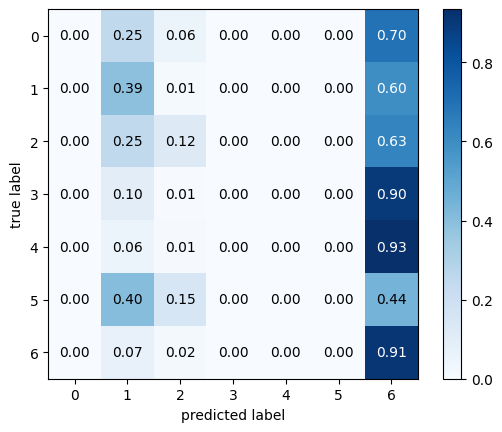

In [ ]:
#Transformer

multiclass = np.array([
    [0, 130, 30, 0, 0, 0, 368],
    [0, 186, 6, 0, 0, 0, 286],
    [0, 79, 39, 0, 0, 0, 201],
    [0, 57, 4, 0, 0, 0, 520],
    [0, 38, 5, 0, 0, 0, 613],
    [0, 98, 37, 0, 0, 0, 108],
    [0, 90, 23, 0, 0, 0, 1138]
])


fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
def calculate_metrics(cm):
    # Extracting TP, FP, FN for each class
    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP
    TN = np.sum(cm) - (FP + FN + TP)

    # Precision, Recall, and F1 Score
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)

    # Class-wise accuracy
    accuracy = (TP + TN) / np.sum(cm)

    return precision, recall, f1, accuracy

precision, recall, f1_score, class_accuracy = calculate_metrics(multiclass)
print(precision)
print(recall)
print(f1_score)
print(class_accuracy)

[       nan 0.27433628 0.27083333        nan        nan        nan
 0.35188621]
[0.         0.38912134 0.12225705 0.         0.         0.
 0.90967226]
[       nan 0.32179931 0.16846652        nan        nan        nan
 0.50746934]
[0.86982249 0.80670611 0.9050789  0.85675542 0.8382643  0.94008876
 0.45537475]


<ipython-input-37-dada11d08927>:10: RuntimeWarning: invalid value encountered in divide
  precision = TP / (TP + FP)


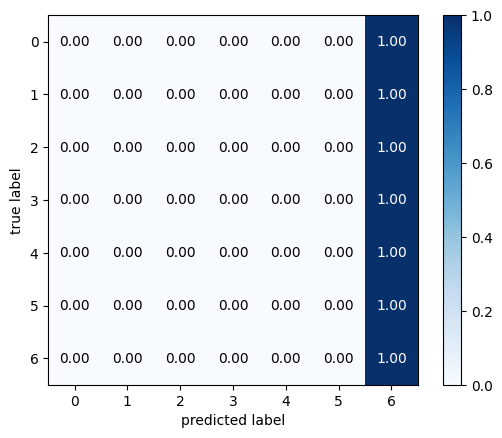

In [ ]:
#LSTM
array_data = [
    [0, 0, 0, 0, 0, 0, 86],
    [0, 0, 0, 0, 0, 0, 96],
    [0, 0, 0, 0, 0, 0, 54],
    [0, 0, 0, 0, 0, 0, 91],
    [0, 0, 0, 0, 0, 0, 87],
    [0, 0, 0, 0, 0, 0, 36],
    [0, 0, 0, 0, 0, 0, 201]
]
multiclass = np.array(array_data)
fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)

In [ ]:
metrics_df_full = pd.DataFrame({
    'Class Label': [0, 1, 2, 3, 4, 5, 6,
                    0, 1, 2, 3, 4, 5, 6,
                    0, 1, 2, 3, 4, 5, 6,
                    0, 1, 2, 3, 4, 5, 6],
    'Batch Size': [8, 8, 8, 8, 8, 8, 8,
                   16, 16, 16, 16, 16, 16, 16,
                   32, 32, 32, 32, 32, 32, 32,
                   64, 64, 64, 64, 64, 64, 64],
    'Precision': [0.87573964, 0.76219512, 0.81914894, 0.72058824, 0.76804124, 0.90769231, 0.81219512,
                  0.7967033, 0.7987013, 0.83908046, 0.695, 0.75280899, 0.7826087, 0.80697674,
                  0.84939759, 0.83211679, 0.81318681, 0.78014184, 0.6763285, 0.84615385, 0.71936759,
                  0.77777778, 0.80597015, 0.8961039,0.74496644,0.63963964,0.94,0.72131148],
    'Recall': [0.85057471, 0.79617834, 0.6754386, 0.8121547, 0.72330097, 0.7972973, 0.84517766,
               0.83333333, 0.78343949, 0.64035088, 0.7679558, 0.65048544, 0.72972973, 0.88071066,
               0.81034483, 0.72611465, 0.64912281, 0.60773481, 0.67961165, 0.59459459, 0.92385787,
               0.8045977, 0.68789809, 0.60526316, 0.61325967, 0.68932039, 0.63513514, 0.89340102],
    'F1-score': [0.86297376, 0.7788162, 0.74038462, 0.76363636, 0.745, 0.84892086, 0.82835821,
                 0.81460674, 0.79099678, 0.72636816, 0.72965879, 0.69791667, 0.75524476, 0.84223301,
                 0.82941176, 0.7755102, 0.72195122, 0.68322981, 0.6779661, 0.6984127, 0.80888889,
                 0.79096045, 0.74226804, 0.72251309, 0.67272727, 0.6635514, 0.75806452, 0.79818594],
    'Class Accuracy': [0.96384615, 0.94538462, 0.95846154, 0.93, 0.92153846, 0.98384615, 0.89384615,
                       0.94923077, 0.95, 0.95769231, 0.92076923, 0.91076923, 0.97307692, 0.9,
                       0.95538462, 0.94923077, 0.95615385, 0.92153846, 0.89769231, 0.97076923, 0.86769231,
                       0.94307692, 0.94230769, 0.95923077, 0.91692308, 0.88923077, 0.97692308,0.86307692]
})

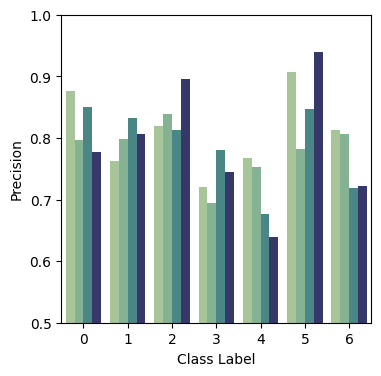

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#data=pd.read_csv("results.txt",sep="\t")
# Filter the DataFrame to only include the Precision column and Batch Size for plotting


# Plot
plt.figure(figsize=(4,4))

# Create a bar plot for Precision colored by Batch Size
precision_plot = sns.barplot(x='Class Label', y='Precision', hue='Batch Size', data=metrics_df_full, palette='crest')

#plt.title('Class Labels vs Precision Colored by Batch Size')
#plt.legend(title='Batch Size')
precision_plot.legend_.remove()
plt.ylim(0.5, 1.0)
plt.show()



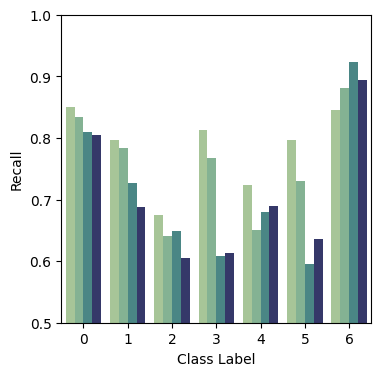

In [ ]:
# Plot
plt.figure(figsize=(4,4))

# Create a bar plot for Precision colored by Batch Size
precision_plot = sns.barplot(x='Class Label', y='Recall', hue='Batch Size', data=metrics_df_full, palette='crest')

#plt.title('Class Labels vs Recall Colored by Batch Size')
#plt.legend(title='Batch Size')
precision_plot.legend_.remove()
plt.ylim(0.5, 1.0)
plt.show()



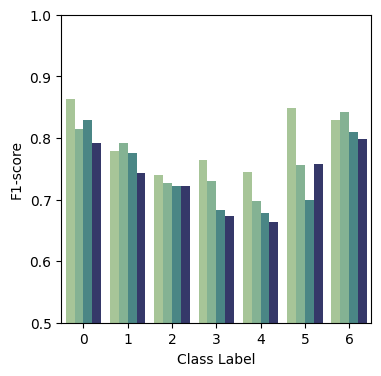

In [ ]:
# Plot
plt.figure(figsize=(4,4))

# Create a bar plot for Precision colored by Batch Size
precision_plot = sns.barplot(x='Class Label', y='F1-score', hue='Batch Size', data=metrics_df_full, palette='crest')

#plt.title('Class Labels vs F1-score Colored by Batch Size')
#plt.legend(title='Batch Size')
precision_plot.legend_.remove()
plt.ylim(0.5, 1.0)
plt.show()



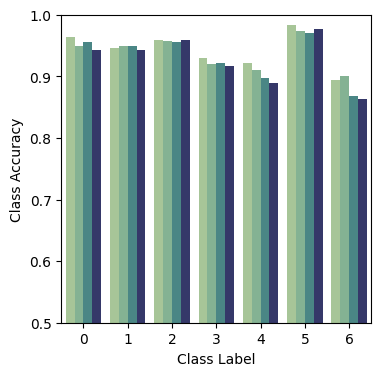

In [ ]:
# Plot
plt.figure(figsize=(4, 4))

# Create a bar plot for Precision colored by Batch Size
precision_plot = sns.barplot(x='Class Label', y='Class Accuracy', hue='Batch Size', data=metrics_df_full, palette='crest')

#plt.title('Class Labels vs Precision Class Accuracy by Batch Size')
#plt.legend(title='Batch Size')
precision_plot.legend_.remove()
plt.ylim(0.5, 1.0)
plt.show()



In [ ]:
#CNN batch=8
df = {
    "Epoch": list(range(1, 31)),
    "Training_Accuracy": [0.33, 0.38, 0.48, 0.59, 0.67, 0.73, 0.77, 0.81, 0.84, 0.87,
                          0.88, 0.89, 0.9, 0.92, 0.92, 0.93, 0.94, 0.95, 0.95, 0.96,
                          0.95, 0.97, 0.97, 0.97, 0.98, 0.98, 0.98, 0.98, 0.99, 0.99],
    "Validation_Accuracy": [0.35, 0.45, 0.54, 0.6, 0.62, 0.66, 0.71, 0.71, 0.75, 0.75,
                            0.75, 0.76, 0.77, 0.78, 0.78, 0.78, 0.79, 0.78, 0.78, 0.77,
                            0.78, 0.79, 0.78, 0.78, 0.77, 0.79, 0.77, 0.78, 0.79, 0.79]
}

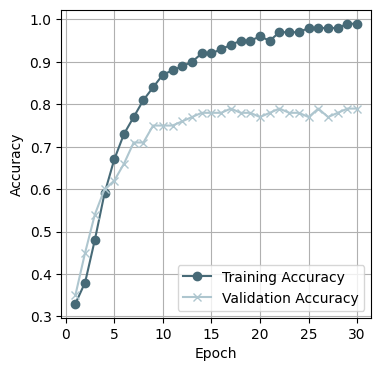

In [ ]:

# Plotting the data
plt.figure(figsize=(4, 4))
plt.plot(df['Epoch'], df['Training_Accuracy'], label='Training Accuracy', marker='o',color="#476A77")
plt.plot(df['Epoch'], df['Validation_Accuracy'], label='Validation Accuracy', marker='x',color="#AEC6CF")
#plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#CNN batch =16
df = {
    'Epoch': list(range(1, 31)),
    'Training_Accuracy': [
        0.31, 0.36, 0.41, 0.48, 0.56, 0.64, 0.7, 0.73, 0.78, 0.8,
        0.81, 0.84, 0.86, 0.87, 0.88, 0.89, 0.9, 0.9, 0.91, 0.92,
        0.92, 0.92, 0.93, 0.94, 0.94, 0.94, 0.95, 0.95, 0.95, 0.96
    ],
    'Validation_Accuracy': [
        0.34, 0.39, 0.4, 0.47, 0.57, 0.62, 0.65, 0.67, 0.67, 0.7,
        0.73, 0.75, 0.75, 0.75, 0.77, 0.76, 0.78, 0.77, 0.76, 0.77,
        0.77, 0.77, 0.78, 0.78, 0.79, 0.79, 0.79, 0.78, 0.8, 0.79
    ]
}

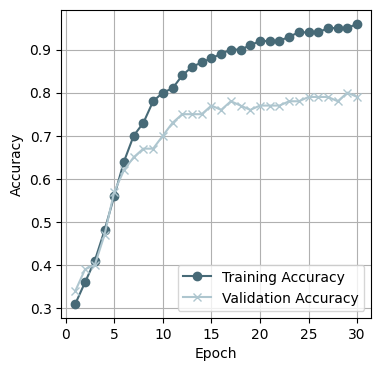

In [ ]:
# Plotting the data
plt.figure(figsize=(4, 4))
plt.plot(df['Epoch'], df['Training_Accuracy'], label='Training Accuracy', marker='o',color="#476A77")
plt.plot(df['Epoch'], df['Validation_Accuracy'], label='Validation Accuracy', marker='x',color="#AEC6CF")
#plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#CNN batch =32
df = {
    'Epoch': list(range(1, 31)),
    'Training_Accuracy': [
        0.32, 0.34, 0.34, 0.36, 0.37, 0.41, 0.47, 0.51, 0.56, 0.59,
        0.64, 0.67, 0.7, 0.72, 0.74, 0.77, 0.78, 0.8, 0.81, 0.82,
        0.84, 0.85, 0.85, 0.86, 0.87, 0.87, 0.88, 0.89, 0.9, 0.9
    ],
    'Validation_Accuracy': [
        0.34, 0.33, 0.35, 0.34, 0.37, 0.45, 0.46, 0.49, 0.56, 0.59,
        0.61, 0.62, 0.65, 0.66, 0.68, 0.65, 0.7, 0.72, 0.72, 0.74,
        0.74, 0.73, 0.74, 0.75, 0.73, 0.74, 0.76, 0.76, 0.76, 0.76
    ]
}

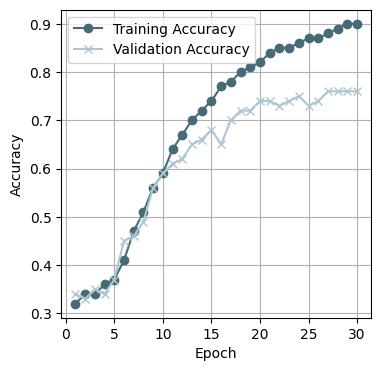

In [ ]:
# Plotting the data
plt.figure(figsize=(4, 4))
plt.plot(df['Epoch'], df['Training_Accuracy'], label='Training Accuracy', marker='o',color="#476A77")
plt.plot(df['Epoch'], df['Validation_Accuracy'], label='Validation Accuracy', marker='x',color="#AEC6CF")
#plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#CNN batch =64

df = {
    'Epoch': list(range(1, 31)),
    'Training_Accuracy': [
        0.31, 0.34, 0.34, 0.36, 0.38, 0.40, 0.43, 0.50, 0.52, 0.57,
        0.61, 0.65, 0.67, 0.70, 0.72, 0.74, 0.76, 0.77, 0.79, 0.80,
        0.81, 0.83, 0.83, 0.84, 0.85, 0.86, 0.86, 0.87, 0.88, 0.88
    ],
    'Validation_Accuracy': [
        0.33, 0.33, 0.34, 0.36, 0.36, 0.43, 0.42, 0.42, 0.52, 0.57,
        0.55, 0.59, 0.62, 0.64, 0.68, 0.66, 0.67, 0.70, 0.71, 0.71,
        0.72, 0.74, 0.75, 0.73, 0.74, 0.76, 0.76, 0.74, 0.76, 0.76
    ]
}


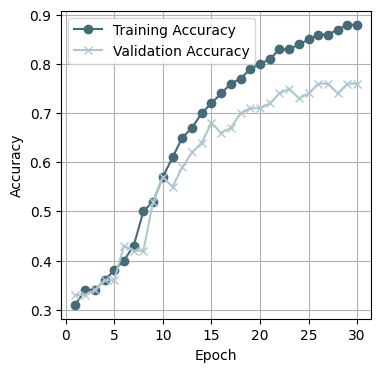

In [ ]:
# Plotting the data
plt.figure(figsize=(4, 4))
plt.plot(df['Epoch'], df['Training_Accuracy'], label='Training Accuracy', marker='o',color="#476A77")
plt.plot(df['Epoch'], df['Validation_Accuracy'], label='Validation Accuracy', marker='x',color="#AEC6CF")
#plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Transormer
df = {
    'Epoch': list(range(1, 31)),
    'Training_Accuracy': [
        30.74, 30.65, 30.74, 31.43, 30.33, 31.95, 31.36, 31.76, 32.22, 32.22,
        32.94, 32.96, 33.28, 31.34, 31.66, 31.53, 32.15, 32.77, 33.26, 32.91,
        33.28, 32.99, 32.91, 33.23, 33.46, 33.36, 33.26, 33.36, 33.11, 32.86
    ],
    'Validation_Accuracy': [
        32.17, 32.17, 32.87, 28.76, 32.17, 32.6, 26.22, 32.6, 33.48, 32.52,
        34.62, 32.87, 31.47, 33.92, 30.59, 33.39, 32.87, 33.57, 33.74, 33.74,
        33.65, 32.69, 34.79, 33.92, 34.27, 34.79, 32.95, 32.95, 34.53, 33.65
    ]
}


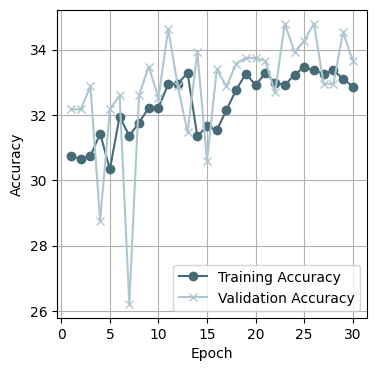

In [ ]:
# Plotting the data
plt.figure(figsize=(4, 4))
plt.plot(df['Epoch'], df['Training_Accuracy'], label='Training Accuracy', marker='o',color="#476A77")
plt.plot(df['Epoch'], df['Validation_Accuracy'], label='Validation Accuracy', marker='x',color="#AEC6CF")
#plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#LSTM
# Create a DataFrame with the provided accuracy values over epochs

# Define the data as a dictionary
df = {
    'Epoch': list(range(1, 31)),
    'Training_Accuracy': [13]+ [28] + [31]*28,
    'Validation_Accuracy': [23] + [32]*29
}




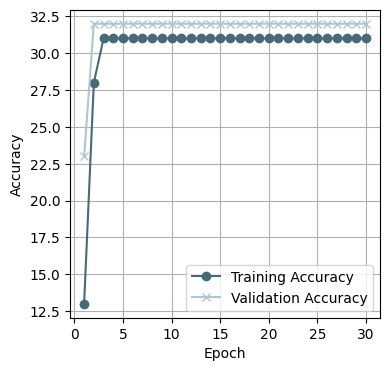

In [ ]:
# Plotting the data
plt.figure(figsize=(4, 4))
plt.plot(df['Epoch'], df['Training_Accuracy'], label='Training Accuracy', marker='o',color="#476A77")
plt.plot(df['Epoch'], df['Validation_Accuracy'], label='Validation Accuracy', marker='x',color="#AEC6CF")
#plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()